In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *
import matplotlib
plt.rcParams.update({'figure.figsize': (4,2.5), 'figure.dpi': 150, 'image.cmap': 'rocket',})

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_17/')

In [4]:
data_df = pd.read_csv(data_path / 'summary.csv').drop(['Unnamed: 0'],axis=1)

In [5]:
data_df['path'] = data_df.apply(lambda x: pathlib.Path(x.path), axis=1)

In [6]:
errors = compute_errors(data_path, target_weights=['weight>=0'])

  0%|          | 0/64 [00:00<?, ?it/s]

In [7]:
for k, df in errors.items():
    errors[k] = pd.merge(
        df, 
        data_df.loc[:, ['path', 'W_condition', 'W_smin', 'W_smax', 'x_condition',
           'x_smin', 'x_smax', 'cov_condition', 'cov_smin', 'cov_smax']],
        on='path'
    )#.query('drive_strength_ex<6')

In [8]:
for k, df in errors.items():
    errors[k]['sigma'] = df.apply(lambda x: x['glorot_normal']['sigma'], axis=1)

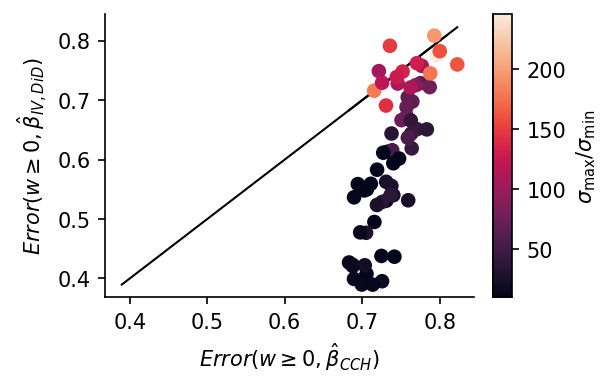

In [9]:
mnorm = matplotlib.colors.LogNorm()
var1 = 'error_naive_cch'
var2 = 'error_beta_iv_did'

for target_weight in errors:
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(3.5,2.5), dpi=150)
    xmin, xmax = errors[target_weight].loc[:,[var1, var2]].min(), errors[target_weight].loc[:,[var1, var2]].max()
    sc = ax.scatter(
        errors[target_weight][var1], 
        errors[target_weight][var2], 
        c=errors[target_weight].cov_condition,
#         norm=mnorm
    )
#     sc = ax.scatter(errors[target_weight][var1], errors[target_weight][var2], c=mnorm(errors[target_weight].cov_condition))
    ax.plot([xmin, xmax], [xmin, xmax], c='k', zorder=0, lw=1)
    lab1 = ",".join([labels[v] for v in var1.split("_")[2:]])
    lab2 = ",".join([labels[v] for v in var2.split("_")[2:]])
    elab = fr'$Error(w > 0, $' if target_weight=='weight>0' else fr'$Error(w = 0, $' if target_weight=='weight==0' else fr'$Error(w \geq 0, $'
    ax.set_xlabel(elab + fr'$\hat{{\beta}}_{{{lab1}}})$')
    ax.set_ylabel(elab + fr'$\hat{{\beta}}_{{{lab2}}})$')
    cbar = plt.colorbar(sc, cax=cax)
#     cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())
#     cbar.ax.set_ylabel(r'$||\mathrm{cov}|| \times ||\mathrm{cov}^{-1}||$')
    cbar.ax.set_ylabel(r'$\sigma_{\mathrm{max}} / \sigma_{\mathrm{min}}$')
    sns.despine()
    savefig(f'sweep_17_confounding_error_condition_{target_weight}')

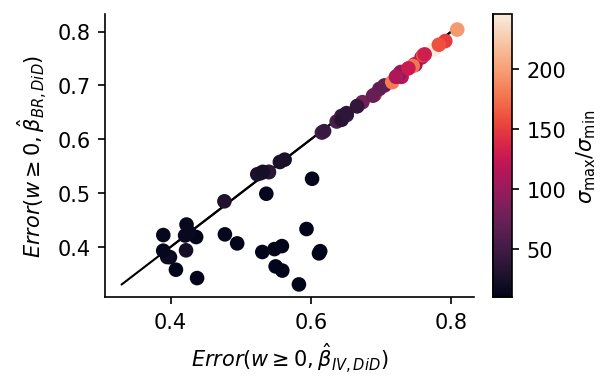

In [31]:
mnorm = matplotlib.colors.LogNorm()
var1 = 'error_beta_iv_did'
var2 = 'error_beta_brew_did'

for target_weight in errors:
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(3.5,2.5), dpi=150)
    xmin, xmax = errors[target_weight].loc[:,[var1, var2]].min(), errors[target_weight].loc[:,[var1, var2]].max()
    sc = ax.scatter(
        errors[target_weight][var1], 
        errors[target_weight][var2], 
        c=errors[target_weight].cov_condition,
#         norm=mnorm
    )
#     sc = ax.scatter(errors[target_weight][var1], errors[target_weight][var2], c=mnorm(errors[target_weight].cov_condition))
    ax.plot([xmin, xmax], [xmin, xmax], c='k', zorder=0, lw=1)
    lab1 = ",".join([labels[v] for v in var1.split("_")[2:]])
    lab2 = ",".join([labels[v] for v in var2.split("_")[2:]])
    elab = fr'$Error(w > 0, $' if target_weight=='weight>0' else fr'$Error(w = 0, $' if target_weight=='weight==0' else fr'$Error(w \geq 0, $'
    ax.set_xlabel(elab + fr'$\hat{{\beta}}_{{{lab1}}})$')
    ax.set_ylabel(elab + fr'$\hat{{\beta}}_{{{lab2}}})$')
    cbar = plt.colorbar(sc, cax=cax)
#     cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())
#     cbar.ax.set_ylabel(r'$||\mathrm{cov}|| \times ||\mathrm{cov}^{-1}||$')
    cbar.ax.set_ylabel(r'$\sigma_{\mathrm{max}} / \sigma_{\mathrm{min}}$')
    sns.despine()
    savefig(f'sweep_17_confounding_error_condition_brew_{target_weight}')

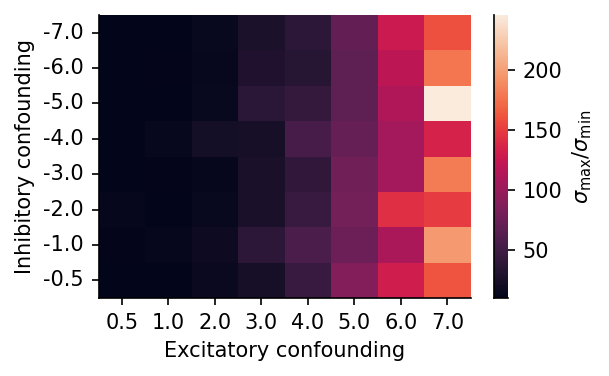

In [10]:
fig, ax = plt.subplots(1,1)
sns.heatmap(
    errors[target_weight].pivot('drive_strength_in', 'drive_strength_ex', 'cov_condition'), ax=ax, 
    cbar_kws={'label': r'$\sigma_{\mathrm{max}} / \sigma_{\mathrm{min}}$'}
#     norm=mnorm
)
ax.set_ylabel('Inhibitory confounding')
ax.set_xlabel('Excitatory confounding')
   
sns.despine()
savefig(f'sweep_17_condition_numbers')

In [11]:
def violin_compare(var1, var2, x='drive_strength_ex', target_weight='weight>0', baselines=None):
    plt.figure()
    key = lambda x: ','.join([labels[l] for l in x.split('_')[2:]])
            
    v1 = errors[target_weight].loc[:, [x, var1]].rename(columns={var1: 'Error'})
    v1[''] = key(var1)
    
    v2 = errors[target_weight].loc[:, [x, var2]].rename(columns={var2: 'Error'})
    v2[''] = key(var2)

    viodf = pd.concat([v1,v2])
    sns.violinplot(
        data=viodf, x=x, y='Error', hue='', split=True, inner="quart", linewidth=1,
        palette={key(var1): colors[key(var1).lower()], key(var2): colors[key(var2).lower()]}, 
        cut=0,
    )

    if baselines is not None:
        for i, (s, df) in enumerate(errors[target_weight].groupby(x)):
            for baseline in baselines:
                plt.plot([i-0.3, i+0.3], [df[baseline].median()]*2, 
                     label=key(baseline) if s==errors[target_weight][x].max() else '', 
                     c=colors[key(baseline).lower()])
    
    sns.despine()
    plt.legend(
        frameon=False,
        bbox_to_anchor=(0,1.0,1,0.2), 
        loc="lower left",
#         mode="expand", 
        borderaxespad=0, ncol=2)
    plt.ylabel('$Error(w > 0)$' if k=='weight>0' else '$Error(w = 0)$')
    plt.xlabel('Drive strength')
#     plt.gca().set_xticklabels([0.0,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0]);
    
    savefig(f'sweep_17_comparison_stim_strength_{target_weight}')

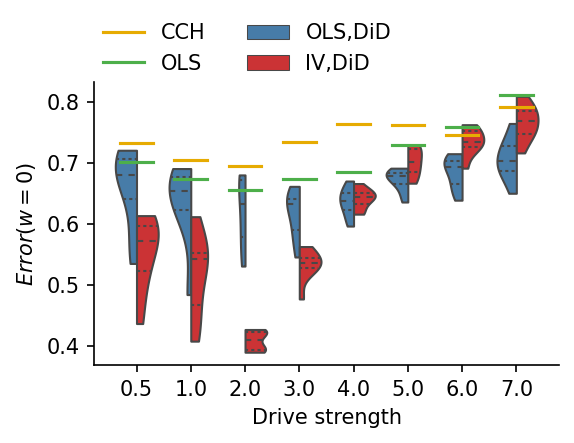

In [12]:
for target_weight in errors:
    violin_compare('error_beta_ols_did', 'error_beta_iv_did', target_weight=target_weight, baselines=['error_naive_cch','error_beta_ols'])
#     violin_compare('error_beta_iv_did', 'error_beta_brew_did', k=k)

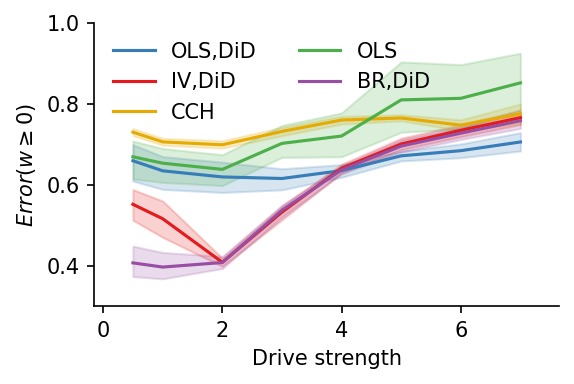

In [62]:
from utils import labels, colors
label = lambda x: ','.join([labels[l] for l in x.split('_')[2:]])
keys = ['error_beta_ols_did', 'error_beta_iv_did', 'error_naive_cch','error_beta_ols', 'error_beta_brew_did']
for target_weight, df in errors.items():
    d = defaultdict(list)
    ekey = '$Error(w > 0)$' if target_weight=='weight>0' else '$Error(w = 0)$' if target_weight=='weight==0' else '$Error(w \geq 0)$'
    for key in keys:
        d[ekey].extend(df[key].values.tolist())
        d['group'].extend([label(key)]*len(df))
        d['Drive strength'].extend(df['drive_strength_ex'].values.tolist())
    plt.figure()
    sns.lineplot(
        data=d,
        x="Drive strength", y=ekey,
        hue="group",
        palette={label(key): colors[label(key).lower()] for key in keys}
    )
    sns.despine()
    plt.legend(frameon=False, ncol=2)
    plt.ylim(0.3, 1.)
    plt.margins(0.1)
    savefig(f'sweep_17_comparison_stim_strength_{target_weight}')

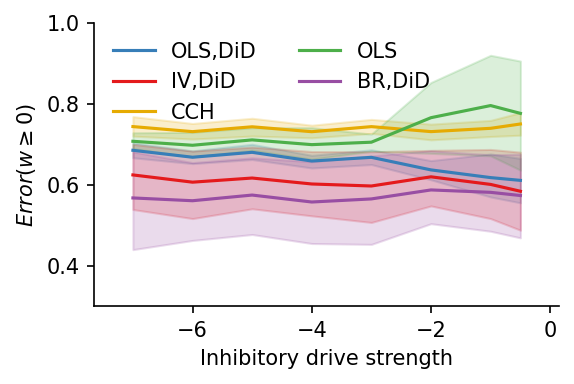

In [65]:
from utils import labels, colors
label = lambda x: ','.join([labels[l] for l in x.split('_')[2:]])
keys = ['error_beta_ols_did', 'error_beta_iv_did', 'error_naive_cch','error_beta_ols', 'error_beta_brew_did']
for target_weight, df in errors.items():
    d = defaultdict(list)
    ekey = '$Error(w > 0)$' if target_weight=='weight>0' else '$Error(w = 0)$' if target_weight=='weight==0' else '$Error(w \geq 0)$'
    for key in keys:
        d[ekey].extend(df[key].values.tolist())
        d['group'].extend([label(key)]*len(df))
        d['Inhibitory drive strength'].extend(df['drive_strength_in'].values.tolist())
    plt.figure()
    sns.lineplot(
        data=d,
        x="Inhibitory drive strength", y=ekey,
        hue="group",
        palette={label(key): colors[label(key).lower()] for key in keys}
    )
    sns.despine()
    plt.legend(frameon=False, ncol=2, loc=2)
    plt.ylim(0.3, 1.)
    plt.margins(0.1)
    savefig(f'sweep_17_comparison_stim_strength_in_{target_weight}')

In [14]:
from utils import violin_compare_all

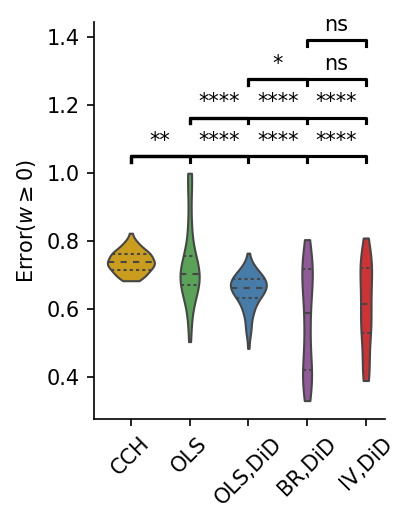

In [45]:
for target_weight in errors:
    violin_compare_all(
        ['error_naive_cch', 
         'error_beta_ols', 
         'error_beta_ols_did',
         'error_beta_brew_did',
         'error_beta_iv_did'], 
        target_weight=target_weight, 
        errors=errors, save='sweep_17_comparison_summary')

# Compare error between OLS and IV

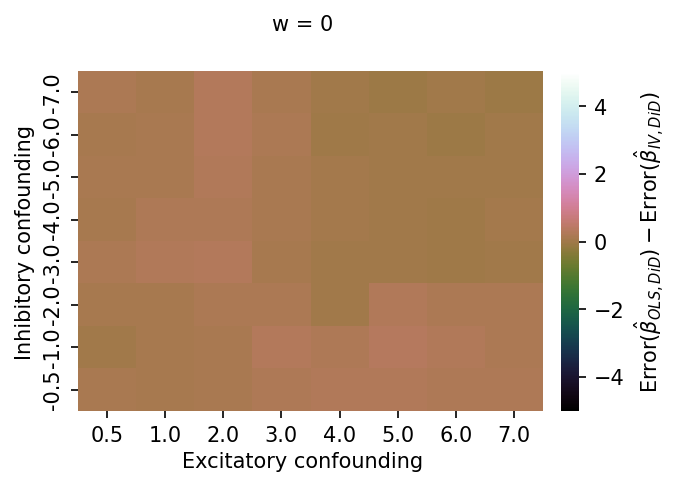

In [16]:
for target_weight, dff in errors.items():
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(4,3))
    cax = fig.add_axes([0.93, 0.125, 0.03, 0.752])
    sns.heatmap(
        dff.pivot('drive_strength_in', 'drive_strength_ex', 'error_beta_ols') - dff.pivot('drive_strength_in', 'drive_strength_ex', 'error_beta_iv_did'), 
#         annot=df.pivot('sigma', 'stim_strength', 'error_diff_ols_iv_did'), 
        cmap='cubehelix', vmin=-5, vmax=5, ax=ax, cbar_ax=cax,
        cbar_kws={'label': r'$\mathrm{Error}(\hat{\beta}_{OLS,DiD}) - \mathrm{Error}(\hat{\beta}_{IV,DiD})$'})
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.text(0.5, 0.0, 'Excitatory confounding', ha='center')
    fig.text(0.02, 0.5, 'Inhibitory confounding', va='center', rotation='vertical')
    fig.text(0.5, 0.97, 'w > 0' if target_weight=='weight>0' else 'w = 0', ha='center')
    savefig(f'sweep_17_confounding_comparison_detailed_{target_weight}')

# Best classifier

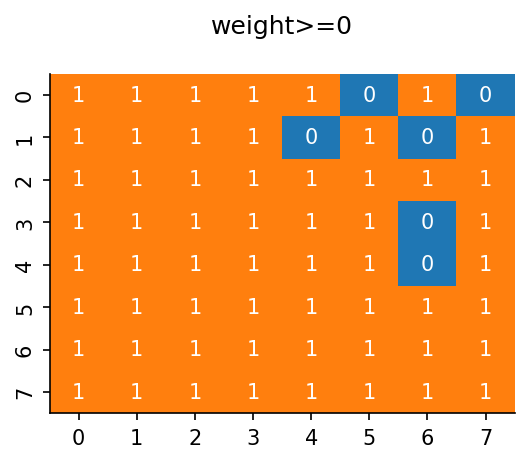

In [17]:
for k, dff in errors.items():
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(4,3))
    argmin_err = np.concatenate(
    [dff.pivot('drive_strength_in', 'drive_strength_ex', 'error_beta_ols').values[:,:,None], 
     dff.pivot('drive_strength_in', 'drive_strength_ex', 'error_beta_iv_did').values[:,:,None], 
#      df.pivot('drive_strength_in', 'drive_strength_ex', 'error_beta_brew_did').values[:,:,None]
    ], axis=2).argmin(2)
    sns.heatmap(
        argmin_err, 
        annot=argmin_err, 
        cmap=['C0', 'C1', 'C2'], vmin=0, vmax=2, ax=ax, cbar=False)

    plt.title(k + '\n')

sns.despine()

# Classificattion

In [18]:
samples = compute_all_samples(data_path)

  0%|          | 0/64 [00:00<?, ?it/s]

In [38]:
keys = ['beta_ols_did', 'beta_iv_did', 'beta_ols', 'naive_cch', 'beta_brew_did']

In [39]:
auroc = []
label = lambda x: ','.join([labels[l] for l in x.split('_')[1:]])
for index, df in samples.items():
#     df = rectify_keys(df, keys)
    ser = df.iloc[0]
    for key in keys:
        a = roc_auc_score(df, key)
        score = {
            'drive_strength_in': ser.drive_strength_in, 
            'drive_strength_ex': ser.drive_strength_ex, 
            'group': label(key),
            'auroc': a
        }
        auroc.append(score)
auroc = pd.DataFrame(auroc)#.query('drive_strength_ex<6')

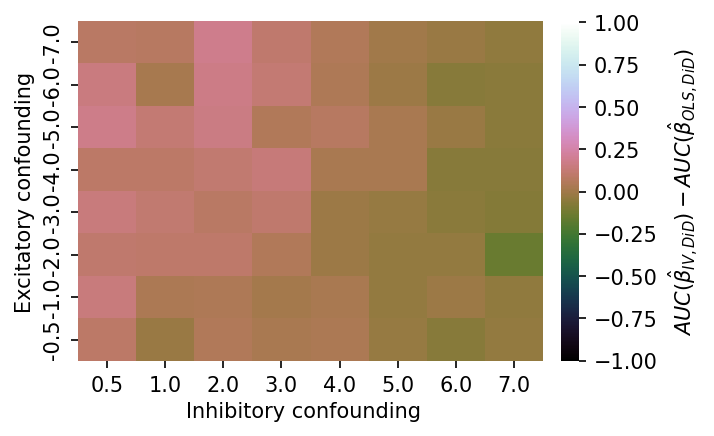

In [40]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(4,3))
cax = fig.add_axes([0.93, 0.125, 0.03, 0.752])
mat = (auroc.query('group=="IV,DiD"').pivot('drive_strength_in', 'drive_strength_ex', 'auroc') - 
       auroc.query('group=="OLS,DiD"').pivot('drive_strength_in', 'drive_strength_ex', 'auroc'))
sns.heatmap(
    mat, cmap='cubehelix', ax=ax, 
    vmin=-1, vmax=1, cbar_ax=cax,
    cbar_kws={'label': r'$AUC(\hat{\beta}_{IV,DiD}) - AUC(\hat{\beta}_{OLS,DiD})$'})
ax.set_ylabel('')
ax.set_xlabel('')

fig.text(0.5, 0.0, 'Inhibitory confounding', ha='center')
fig.text(0.02, 0.5, 'Excitatory confounding', va='center', rotation='vertical')
savefig(f'sweep_17_confounding_auroc_difference')

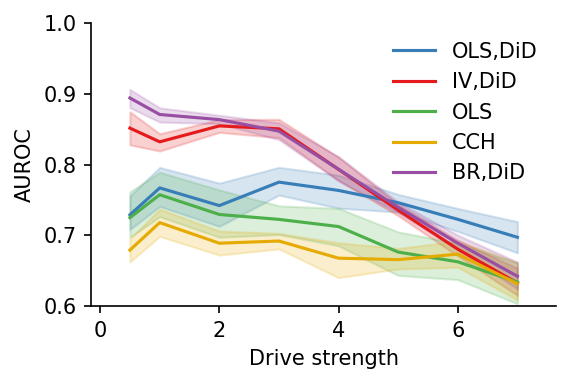

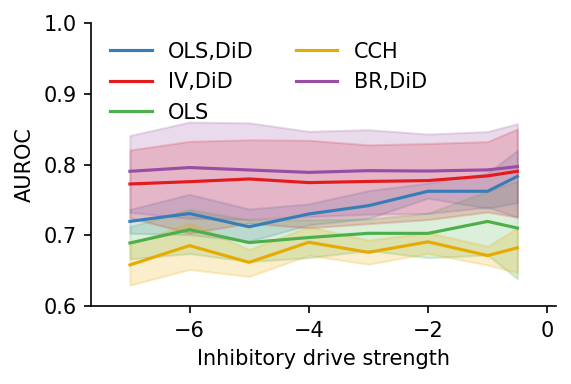

In [66]:
plt.figure()
sns.lineplot(
    data=auroc,#.sort_values('n_neurons'),
    x="drive_strength_ex", y='auroc',
    hue="group",
    palette={label(key): colors[label(key).lower()] for key in keys}
)
plt.ylabel('AUROC')
plt.xlabel('Drive strength')
plt.ylim(0.6, 1)
plt.margins(0.1)
sns.despine()
plt.legend(frameon=False)
savefig(f'sweep_17_auroc_ex_strength')

plt.figure()
sns.lineplot(
    data=auroc,#.sort_values('n_neurons'),
    x="drive_strength_in", y='auroc',
    hue="group",
    palette={label(key): colors[label(key).lower()] for key in keys}
)
plt.ylabel('AUROC')
plt.xlabel('Inhibitory drive strength')
plt.ylim(0.6, 1.)
plt.margins(0.1)
sns.despine()
plt.legend(frameon=False, ncol=2, loc=2)
savefig(f'sweep_17_auroc_in_strength')

# Regression

In [42]:
concsamples = pd.concat([v for v in samples.values()])
# concsamples['ww'] = concsamples['weight'].round(3)

In [24]:
# concsamples = concsamples.groupby('ww').sample(1)

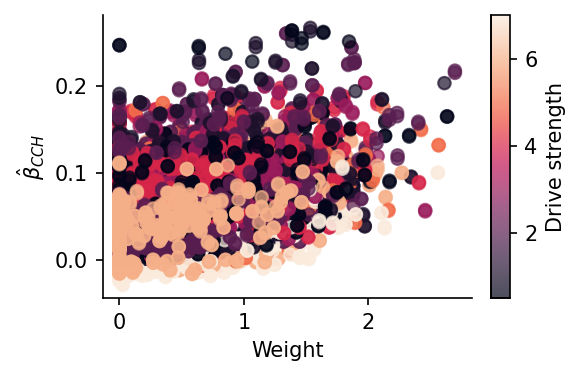

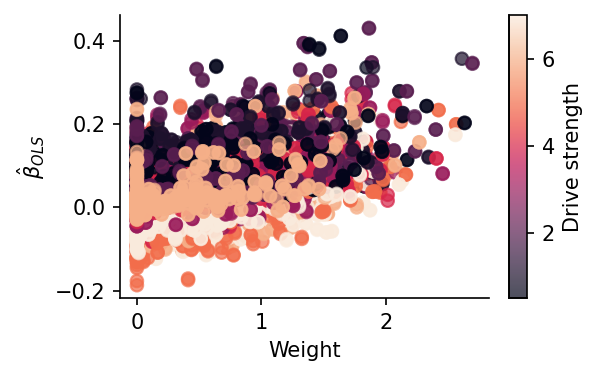

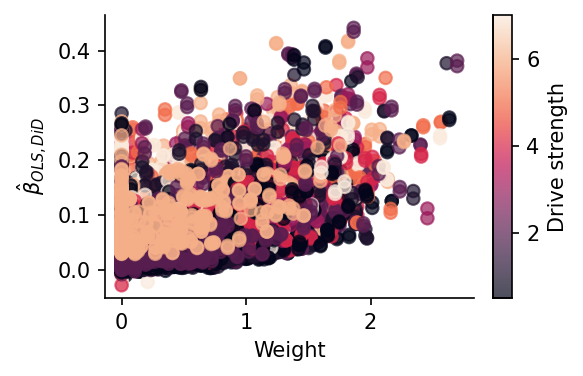

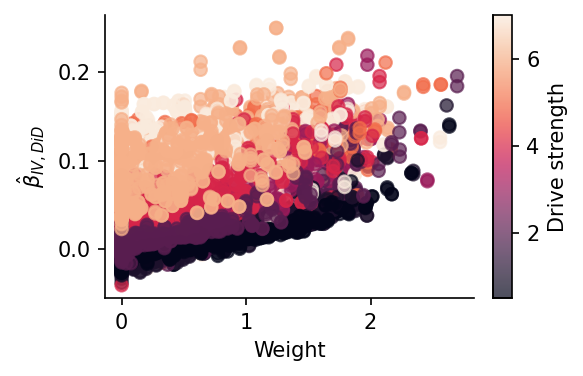

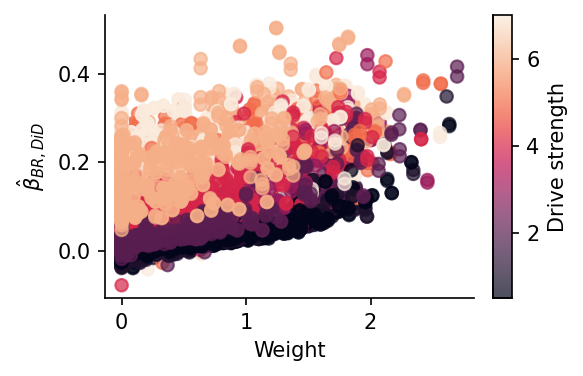

In [43]:
for key in ['naive_cch', 'beta_ols', 'beta_ols_did', 'beta_iv_did', 'beta_brew_did']:
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(3.5,2.5), dpi=150)
    sc = ax.scatter(
        concsamples['weight'],
        concsamples[key],
        c=concsamples['drive_strength_ex'],
        alpha=0.7
    )
    lab = ",".join([labels[v] for v in key.split("_")[1:]])
    ax.set_xlabel('Weight')
    ax.set_ylabel(fr'$\hat{{\beta}}_{{{lab}}}$')
    cbar = plt.colorbar(sc, cax=cax)
    cbar.ax.set_ylabel('Drive strength')
    sns.despine()
    savefig(f'sweep_17_scatter_{key}')

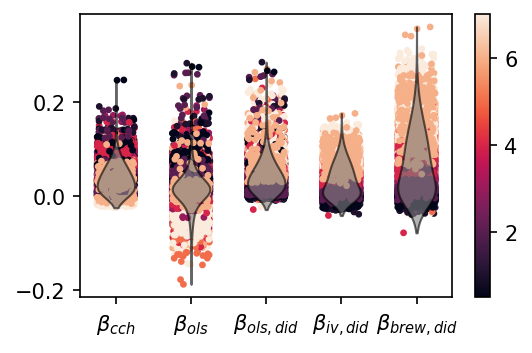

In [44]:
plot_false_positives(concsamples.query('weight==0'),# and drive_strength_ex<6'), 
                     ['naive_cch', 'beta_ols', 'beta_ols_did', 'beta_iv_did', 'beta_brew_did'], 
                     scatter_color='drive_strength_ex')

In [27]:
abs(samples[index].query('weight==0')[['beta_ols_did', 'beta_iv_did', 'beta_ols']].values).sum(axis=0)

array([15.81481273, 15.74867986,  4.7270442 ])

In [28]:
[error_norm(1, samples[index].query('weight==0'), key) for key in ['beta_ols_did', 'beta_iv_did', 'beta_ols']]

[1.1949578622169394, 1.1173546559463676, 0.46899559887151876]

In [29]:
samples[index].query('weight==0').loc[:,['beta_ols_did', 'beta_iv_did', 'beta_ols']].std()

beta_ols_did    0.036924
beta_iv_did     0.024372
beta_ols        0.027040
dtype: float64